# French Keyboard Layout Optimisation

**Author:** Adesh Maharaj 20019971  
**Date:** August 2025  

This notebook applies the same optimisation pipeline described in the English notebook to the **French corpus (Tatoeba full sentences)**.  

The English notebook contains extensive annotations explaining the methodology, genetic algorithm setup, and evaluation pipeline.  
To avoid repetition, this notebook includes only light commentary while demonstrating the application of the same logic to French text.  


In [ ]:
from collections import Counter
import math
import pandas as pd
import matplotlib.pyplot as plt
from metrics_collector import MetricsCollector
import pprint
import random
import numpy as np

# --- Imports from MKLOGA ---
from characters_placement import CharactersPlacement
from button import Button


In [ ]:

# 26 base letters
base_letters = list("abcdefghijklmnopqrstuvwxyz")

# Common accented letters in French (from AZERTY, BÉPO, French NLP corpora)
accented_letters = list("àâäçéèêëîïôöùûüÿœ")

# Common punctuation used in French writing
punctuation_chars = list(".,;:!?()'\"-=@#+<>[]$%^&*_|µ/")

# Merge full character pool
CHARACTER_SET = base_letters + accented_letters + punctuation_chars
CHARACTER_SET = list(sorted(set(CHARACTER_SET)))  # remove any accidental duplicates

print(f"Full character pool size: {len(CHARACTER_SET)}")
valid_chars = set(CHARACTER_SET)


NUMBER_ROW = [(i, -1) for i in range(12)]
TOP_ROW = [(i + 0.5, 0) for i in range(12)]
HOME_ROW = [(i + 1, 1) for i in range(12)]
BOTTOM_ROW = [(i + 0.5, 2) for i in range(11)]

KEYBOARD_POSITIONS = NUMBER_ROW + TOP_ROW + HOME_ROW + BOTTOM_ROW
assert len(KEYBOARD_POSITIONS) == 47


Full character pool size: 71


In [ ]:
AZERTY_CHARS = list(
    "&é\"'(-è_çà)=" +                  # Top symbol row
    "azertyuiop[]" +                   # Top letter row
    "qsdfghjklmù*" +                   # Home row
    "<wxcvbn,;:!"                        # Bottom row
)
AZERTY_CHARS = AZERTY_CHARS[:47]  # Force trim to 47
assert len(AZERTY_CHARS) == 47

BEPO_CHARS = list(
    "\"<>()@+-/*=%" +
    "bépoè!vdljzw" +                 # Top row
    "auie,ctsrnmç" +                 # Home row
    "êàyx.k'qghf"                    # Bottom row
)
BEPO_CHARS = list(dict.fromkeys(BEPO_CHARS))  # Remove duplicates
BEPO_CHARS = [c for c in BEPO_CHARS if c in CHARACTER_SET]
BEPO_CHARS = BEPO_CHARS[:47]
assert len(BEPO_CHARS) == 47



KEYBOARD_POSITIONS = NUMBER_ROW + TOP_ROW + HOME_ROW + BOTTOM_ROW
assert len(KEYBOARD_POSITIONS) == 47, f"Expected 47 key positions, got {len(KEYBOARD_POSITIONS)}"

# --- Create Button objects ---
buttons = []
for idx, (x, y) in enumerate(KEYBOARD_POSITIONS):
    buttons.append(Button(
        id=idx,
        location={'x': x, 'y': y},
        size={'width': 1.0, 'height': 1.0}
    ))

azerty_layout = CharactersPlacement([
    {'character': ch, 'button_id': i}
    for i, ch in enumerate(AZERTY_CHARS)
])
print("Functional AZERTY layout loaded.")

bepo_layout = CharactersPlacement([
    {'character': ch, 'button_id': i}
    for i, ch in enumerate(BEPO_CHARS)
])
print("Functional BÉPO layout loaded.")



Functional AZERTY layout loaded.
Functional BÉPO layout loaded.


/tmp/ipython-input-274456677.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle((x, y), w, h, fill=True, color="#d3d3d3", edgecolor='black'))


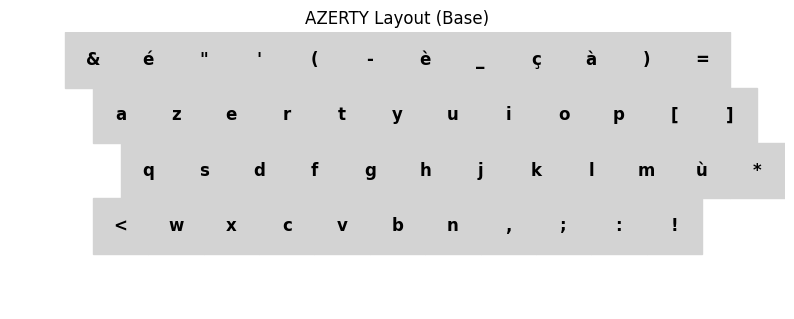

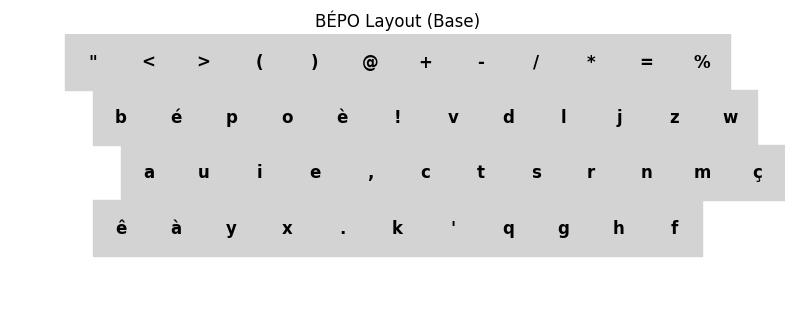

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_keyboard(layout, buttons, title="Keyboard Layout"):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_aspect('equal')

    for char_obj in layout.characters_set:
        btn = buttons[char_obj.button_id]
        x, y = btn.location.x, btn.location.y
        w, h = btn.size.width, btn.size.height

        ax.add_patch(Rectangle((x, y), w, h, fill=True, color="#d3d3d3", edgecolor='black'))
        ax.text(x + w/2, y + h/2, char_obj.character,
                ha='center', va='center', fontsize=12, fontweight='bold')

    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 4)
    ax.invert_yaxis()
    ax.axis('off')
    plt.title(title)
    plt.show()

visualize_keyboard(azerty_layout, buttons, title="AZERTY Layout (Base)")
visualize_keyboard(bepo_layout, buttons, title="BÉPO Layout (Base)")

In [ ]:
import re
from collections import Counter

VALID_CHARS = set(CHARACTER_SET)

def load_and_extract_bigrams_from_txt(txt_path, valid_chars=None):
    with open(txt_path, 'r', encoding='utf-8') as f:
        text_data = f.read().lower()

    # Clean based on valid characters
    if valid_chars:
        text_data = ''.join([c for c in text_data if c in valid_chars])
    else:
        text_data = re.sub(r'[^a-z]', '', text_data)

    bigrams = [text_data[i:i+2] for i in range(len(text_data) - 1)]
    bigram_counts = Counter(bigrams)
    total = sum(bigram_counts.values())
    bigram_freq = {bg: count / total for bg, count in bigram_counts.items()}

    print(f"Loaded {len(bigram_freq)} unique bigrams from corpus.")
    return bigram_freq

def compute_char_freq_from_bigrams(bigram_freq):
    char_freq = Counter()
    for (a, b), prob in bigram_freq.items():
        char_freq[a] += prob / 2
        char_freq[b] += prob / 2
    return dict(char_freq)

In [ ]:
bigram_freq = load_and_extract_bigrams_from_txt("fr.txt", valid_chars=VALID_CHARS)
char_freq = compute_char_freq_from_bigrams(bigram_freq)


# Show most common bigrams and characters for prompting
top_12_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)[:12]
top_12_chars = sorted(char_freq.items(), key=lambda x: x[1], reverse=True)[:12]

print("\nTop 12 bigrams:")
for bg, freq in top_12_bigrams:
    print(f"{bg}: {freq:.4f}")

print("\nTop 12 characters:")
for ch, freq in top_12_chars:
    print(f"{ch}: {freq:.4f}")

# Get top 47 most frequent characters from the corpus
def get_top_characters(char_freq, top_n):
    sorted_chars = [char for char, _ in Counter(char_freq).most_common(top_n)]
    return sorted_chars

top_chars_pool = get_top_characters(char_freq, top_n=47)

print(top_chars_pool)



Loaded 2135 unique bigrams from corpus.

Top 12 bigrams:
es: 0.0255
en: 0.0198
le: 0.0179
ou: 0.0157
ai: 0.0157
re: 0.0156
on: 0.0137
nt: 0.0132
de: 0.0131
er: 0.0118
te: 0.0113
is: 0.0110

Top 12 characters:
e: 0.1411
s: 0.0801
a: 0.0743
i: 0.0665
t: 0.0652
n: 0.0646
u: 0.0607
r: 0.0594
o: 0.0536
l: 0.0509
d: 0.0292
m: 0.0289
['e', 's', 'a', 'i', 't', 'n', 'u', 'r', 'o', 'l', 'd', 'm', 'p', 'c', '.', 'v', 'é', "'", 'j', 'q', 'f', 'b', 'g', 'h', '-', ',', 'à', '?', 'x', 'è', 'z', 'y', 'ê', '!', 'ç', 'î', 'k', 'ô', 'â', 'ù', 'û', 'œ', '"', ':', 'w', ';', '/']


In [ ]:
from collections import defaultdict

def build_finger_map(buttons):
    """
    Maps each button ID to a finger ID based on x-position.
    Finger IDs: 0–4 left hand, 5–9 right hand.
    """
    finger_map = {}
    for btn in buttons:
        x = btn.location.x
        id = btn.id
        # Simplified 10-finger mapping based on x position
        if x <= 1:
            finger_map[id] = 0  # Left pinky
        elif x <= 2:
            finger_map[id] = 1  # Left ring
        elif x <= 3:
            finger_map[id] = 2  # Left middle
        elif x <= 4:
            finger_map[id] = 3  # Left index
        elif x <= 5:
            finger_map[id] = 4  # Left index (shared zone)
        elif x <= 6:
            finger_map[id] = 5  # Right index (shared zone)
        elif x <= 7:
            finger_map[id] = 6  # Right index
        elif x <= 8:
            finger_map[id] = 7  # Right middle
        elif x <= 9:
            finger_map[id] = 8  # Right ring
        else:
            finger_map[id] = 9  # Right pinky
    return finger_map

FINGER_STRAIN_WEIGHT = {
    0: 1.2,  # Left pinky
    1: 1.0,  # Left ring
    2: 0.8,  # Left middle
    3: 0.6,  # Left index
    4: 0.5,  # Shared
    5: 0.5,  # Shared
    6: 0.6,  # Right index
    7: 0.8,  # Right middle
    8: 1.0,  # Right ring
    9: 1.2   # Right pinky
}

def compute_finger_penalty(layout, char_freq, finger_map):
    finger_load = defaultdict(float)
    for ch_obj in layout.characters_set:
        ch = ch_obj.character
        if ch in char_freq:
            finger = finger_map.get(ch_obj.button_id)
            finger_load[finger] += char_freq[ch]

    finger_penalty = sum(
        load * FINGER_STRAIN_WEIGHT.get(finger, 1.0)
        for finger, load in finger_load.items()
    )
    return finger_penalty


In [ ]:

def row_of(btn):
    return int(round(btn.location.y))

def is_left_hand(x):
    return x < 5  # crude left/right split

def compute_carpalx_fitness(layout, buttons, bigram_freq, char_freq=None, home_row_indices=None, *, return_components=False):
    dist_weight = 0.5
    ROW_WEIGHT = {-1: 3.0,  #'number' top row (hardest to reach)
                  0: 2,     # top row
                  1: 1.0,   # home row (where we want our most used)
                  2: 2.5}   # bottom row

    char_pos = {}
    for char_obj in layout.characters_set:
        btn = buttons[char_obj.button_id]
        char_pos[char_obj.character] = btn

    # 🆕 Create finger map once per layout
    finger_map = build_finger_map(buttons)
    char_to_finger = {
        char_obj.character: finger_map[char_obj.button_id]
        for char_obj in layout.characters_set
    }

    base_cost = 0.0
    alternation_bonus = 0.0
    same_finger_penalty = 0.0
    row_penalty = 0.0
    home_row_bonus = 0.0
    missing = 0
    #missing_chars = set() For checking what charcters the keyboards are missing

    for bg, p in bigram_freq.items():
        a, b = bg
        if a not in char_pos or b not in char_pos:
            # For following what base layout is missing
            #if a not in char_pos:
            #    missing_chars.add(a)
            #if b not in char_pos:
            #   missing_chars.add(b)
            missing += 1
            continue

        #print(f"Missing characters: {sorted(missing_chars)}")


        btn_a = char_pos[a]
        btn_b = char_pos[b]
        xa, ya = btn_a.location.x, btn_a.location.y
        xb, yb = btn_b.location.x, btn_b.location.y

        dist = math.hypot(xa - xb, ya - yb)
        avg_row_pen = 0.5 * (ROW_WEIGHT.get(row_of(btn_a), 1.0) + ROW_WEIGHT.get(row_of(btn_b), 1.0))

        base_cost += p * dist_weight * dist * avg_row_pen

        # Hand alternation (same as before)
        if is_left_hand(xa) != is_left_hand(xb):
            alternation_bonus += 0.5 * p

        # Same-finger penalty using finger IDs
        if char_to_finger.get(a) == char_to_finger.get(b):
            same_finger_penalty += 0.4 * p

    if char_freq and home_row_indices:
        for idx, char_obj in enumerate(layout.characters_set):
            char = char_obj.character
            if char in char_freq:
                if idx in home_row_indices:
                    home_row_bonus += 1.2 * char_freq[char]
                y = row_of(buttons[char_obj.button_id])
                row_penalty += 0.1 * char_freq[char] * ROW_WEIGHT.get(y, 1.0)

    SYMBOLS = set("[]{}()<>/\\|@#$%^&*_+=~`")
    symbol_penalty = 0.0
    for idx in home_row_indices:
        char = layout.characters_set[idx].character
        if char in SYMBOLS:
            symbol_penalty += 1  # adjust strength

    finger_penalty = compute_finger_penalty(layout, char_freq, finger_map)

    final_score = -base_cost + alternation_bonus - same_finger_penalty + home_row_bonus - row_penalty - symbol_penalty - finger_penalty

    if return_components:
        return final_score, missing, {
            "base_cost": base_cost,
            "alternation_bonus": alternation_bonus,
            "same_finger_penalty": same_finger_penalty,
            "home_row_bonus": home_row_bonus,
            "row_penalty": row_penalty,
            "symbol_penalty": symbol_penalty,
            "finger_penalty": finger_penalty,
        }

    return final_score, missing


In [ ]:
def get_home_row_indices(layout, buttons):
    for char_obj in layout.characters_set:
        assert 0 <= char_obj.button_id < len(buttons), (
            f"Invalid button_id {char_obj.button_id} (buttons only has {len(buttons)} entries)"
        )
    return [
        idx for idx, char_obj in enumerate(layout.characters_set)
        if round(buttons[char_obj.button_id].location.y) == 1
    ]


char_freq = Counter()  # optional: compute from corpus

# simple char freq from bigrams
for bg, p in bigram_freq.items():
    char_freq[bg[0]] += p
    char_freq[bg[1]] += p

def compute_layout_coverage(layout, bigram_freq):
    layout_chars = {ch.character for ch in layout.characters_set}

    total_bigrams = len(bigram_freq)
    typable_bigrams = sum(
        1 for bg in bigram_freq if bg[0] in layout_chars and bg[1] in layout_chars
    )

    return typable_bigrams / total_bigrams if total_bigrams else 0

for name, layout in [("AZERTY", azerty_layout), ("BEPO", bepo_layout)]:
    home_row_indices = get_home_row_indices(layout, buttons)

    layout_chars = {ch.character for ch in layout.characters_set}
    filtered_bigrams = {
        bg: p for bg, p in bigram_freq.items() if bg[0] in layout_chars and bg[1] in layout_chars
    }

    score, _ = compute_carpalx_fitness(layout, buttons, filtered_bigrams, char_freq, home_row_indices)
    coverage = compute_layout_coverage(layout, bigram_freq)

    print(f"{name} → Fitness: {score:.4f} | Coverage: {coverage:.2%}")

for name, layout in [("AZERTY", azerty_layout), ("BEPO", bepo_layout)]:
    home_row_indices = get_home_row_indices(layout, buttons)
    score, missing = compute_carpalx_fitness(layout, buttons, bigram_freq, char_freq, home_row_indices)
    print(f"{name} Scores → {score:.4f} Missing → {missing:.4f}")


AZERTY → Fitness: -5.3458 | Coverage: 67.68%
BEPO → Fitness: -2.8823 | Coverage: 70.40%
AZERTY Scores → -5.3458 Missing → 690.0000
BEPO Scores → -2.8823 Missing → 632.0000


In [ ]:
# Here we take top_n numebr of the top characters to create some diversity if needed
top_chars_pool = get_top_characters(char_freq, top_n=47)

print(top_chars_pool)

['e', 's', 'a', 'i', 't', 'n', 'u', 'r', 'o', 'l', 'd', 'm', 'p', 'c', '.', 'v', 'é', "'", 'j', 'q', 'f', 'b', 'g', 'h', '-', ',', 'à', '?', 'x', 'è', 'z', 'y', 'ê', '!', 'ç', 'î', 'k', 'ô', 'â', 'ù', 'û', 'œ', '"', ':', 'w', ';', '/']


In [ ]:
def summarize_layout(layout, buttons, bigram_freq, char_freq, name="Layout",
                     home_row_indices=None):
    """
    Return a dict of fitness/components plus coverage and same-finger % for a layout.
    """
    # ---- fitness + components ----
    try:
        score, missing, comp = compute_carpalx_fitness(
            layout, buttons, bigram_freq, char_freq,
            home_row_indices=home_row_indices, return_components=True
        )
        fitness = float(score)
        components = {
            "base_cost":           float(comp.get("base_cost", 0.0)),
            "alternation_bonus":   float(comp.get("alternation_bonus", 0.0)),
            "same_finger_penalty": float(comp.get("same_finger_penalty", 0.0)),
            "home_row_bonus":      float(comp.get("home_row_bonus", 0.0)),
            "row_penalty":         float(comp.get("row_penalty", 0.0)),
            "symbol_penalty":      float(comp.get("symbol_penalty", 0.0)),
            "finger_penalty":      float(comp.get("finger_penalty", 0.0)),
        }
    except TypeError:
        score, missing = compute_carpalx_fitness(
            layout, buttons, bigram_freq, char_freq, home_row_indices=home_row_indices
        )
        fitness = float(score)
        components = {}

    # ---- coverage (% of unique bigram TYPES present) ----
    total_types = max(1, len(bigram_freq))
    coverage_pct = 100.0 * (1.0 - float(missing) / total_types)

    # ---- same-finger percentage ----
    char_to_btn = {obj.character: buttons[obj.button_id]
                   for obj in getattr(layout, "characters_set", [])}

    def infer_finger(btn):
        if hasattr(btn, "finger") and btn.finger:
            return str(btn.finger)
        x = getattr(getattr(btn, "location", None), "x", None)
        if x is None:
            return "?"
        if x < 5:
            return "L1" if x >= 4 else "L2" if x >= 3 else "L3" if x >= 2 else "L4" if x >= 1 else "L5"
        else:
            return "R1" if x < 6 else "R2" if x < 7 else "R3" if x < 8 else "R4" if x < 9 else "R5"

    sfb_weight = 0.0
    total_weight = 0.0
    for (a, b), w in bigram_freq.items():
        ba = char_to_btn.get(a)
        bb = char_to_btn.get(b)
        if ba is None or bb is None:
            continue
        total_weight += w
        if infer_finger(ba) == infer_finger(bb):
            sfb_weight += w
    same_finger_pct = (sfb_weight / total_weight * 100.0) if total_weight > 0 else 0.0

    # ---- assemble ----
    return {
        "layout": name,
        "fitness": fitness,
        "coverage": coverage_pct,
        "same_finger_pct": same_finger_pct,
        "missing_bigrams": int(missing),
        **components,
    }


In [ ]:
# Build home row indices for each layout (re‑use your helper)
azerty_home = get_home_row_indices(azerty_layout, buttons)
ga_home     = get_home_row_indices(bepo_layout, buttons)
# llm_home    = get_home_row_indices(layout_fr_llm, buttons)   # if you have an LLM layout

finger_map = build_finger_map(buttons)

rows = []
rows.append(summarize_layout(azerty_layout, buttons, bigram_freq, char_freq, name="AZERTY",   home_row_indices=azerty_home))
rows.append(summarize_layout(bepo_layout, buttons, bigram_freq, char_freq, name="BEPO",  home_row_indices=ga_home))


df_compare = pd.DataFrame(rows).round(3)
df_compare


,layout,fitness,coverage,same_finger_pct,missing_bigrams,base_cost,alternation_bonus,same_finger_penalty,home_row_bonus,row_penalty,symbol_penalty,finger_penalty
0,AZERTY,-5.346,67.681,9.900,690,3.168,0.238,0.031,0.567,0.362,1.0,1.59
1,BEPO,-2.882,70.398,7.032,632,2.853,0.326,0.021,1.618,0.272,0.0,1.68


In [ ]:
a = summarize_layout(
    azerty_layout,
    buttons,
    bigram_freq,
    char_freq,
    name="AZERTY",
    home_row_indices=get_home_row_indices(azerty_layout, buttons),
)

b = summarize_layout(
    bepo_layout,
    buttons,
    bigram_freq,
    char_freq,
    name="BEPO",
    home_row_indices=get_home_row_indices(azerty_layout, buttons),
)

pprint.pprint(a)
pprint.pprint(b)

{'alternation_bonus': 0.23778202307155494,
 'base_cost': 3.168205532716801,
 'coverage': 67.68149882903981,
 'finger_penalty': 1.5897952702048768,
 'fitness': -5.345755457924614,
 'home_row_bonus': 0.5674095994339273,
 'layout': 'AZERTY',
 'missing_bigrams': 690,
 'row_penalty': 0.36164463344288017,
 'same_finger_pct': 9.899544261422607,
 'same_finger_penalty': 0.03130164406553918,
 'symbol_penalty': 1.0}
{'alternation_bonus': 0.3256219780386656,
 'base_cost': 2.8528179686046466,
 'coverage': 70.39812646370022,
 'finger_penalty': 1.6803004616089579,
 'fitness': -2.8823135619685574,
 'home_row_bonus': 1.618352857795828,
 'layout': 'BEPO',
 'missing_bigrams': 632,
 'row_penalty': 0.2722091629801901,
 'same_finger_pct': 7.032242242690977,
 'same_finger_penalty': 0.020960804609255982,
 'symbol_penalty': 0.0}


In [ ]:
print("Len buttons:", len(buttons))
print("Max button_id in layout:", max(c.button_id for c in layout.characters_set))


Len buttons: 47
Max button_id in layout: 46


In [ ]:
# --- Create a random genome from the top characters pool ---
def create_random_genome():
    genome = random.sample(top_chars_pool, 47)
    return genome

# CharactersPlacement and Button. This function wraps the conversion:
def genome_to_layout(genome):
    """
    Converts a genome (list of 47 characters) to a CharactersPlacement layout object.
    """
    return CharactersPlacement([
        {'character': ch, 'button_id': i}
        for i, ch in enumerate(genome[:len(buttons)])  # ✅ limit to button count
    ])

# Evaluates the genome
def evaluate_genome(genome, buttons, bigram_freq, char_freq):
    layout = genome_to_layout(genome)
    home_row_indices = get_home_row_indices(layout, buttons)

    # Must return (score, breakdown_dict)
    score, missing, breakdown = compute_carpalx_fitness(
        layout, buttons, bigram_freq, char_freq,
        home_row_indices=home_row_indices,
        return_components=True
    )
    return score, breakdown


In [ ]:
# Mutation
def mutate_genome(genome, mutation_rate):
    """
    Randomly swap two mutable characters in the genome (excluding fixed characters).
    """
    genome = genome[:]  # copy
    if random.random() < mutation_rate:
        i, j = random.sample(range(10, len(genome)), 2)  # only mutable part
        genome[i], genome[j] = genome[j], genome[i]
    return genome

# Crossover using OX
def order_crossover(parent1, parent2):
    """
    Order Crossover (OX) for permutations, keeping first 10 characters fixed.
    """
    start, end = sorted(random.sample(range(10, len(parent1)), 2))

    # Inherit slice from Parent 1
    child = [None] * len(parent1)
    child[start:end] = parent1[start:end]

    # Fill remaining from Parent 2 in order
    p2_filtered = [ch for ch in parent2 if ch not in child[start:end]]

    j = 0
    for i in range(len(parent1)):
        if i >= start and i < end:
            continue
        child[i] = p2_filtered[j]
        j += 1

    return child


In [ ]:
# Population Initialisation
def create_initial_population(pop_size):
    population = []
    while len(population) < pop_size:
        genome = create_random_genome()
        layout = genome_to_layout(genome)
        coverage = compute_layout_coverage(layout, bigram_freq)
        if coverage > 0.8:
            population.append(genome)
    return population

# Tournament selection
def tournament_selection(population, fitnesses, k=3):
    selected = random.sample(list(zip(population, fitnesses)), k)
    selected.sort(key=lambda x: -x[1])  # Higher fitness is better
    return selected[0][0]  # Return best genome


In [ ]:
def run_ga(buttons, bigram_freq, char_freq, generations, pop_size, mutation_rate, random_seed, *, metrics=None):
    random.seed(random_seed)
    np.random.seed(random_seed)

    # metrics setup (French GA is MAXimizing)
    if metrics is None:
        metrics = MetricsCollector(maximize=True)
    metrics.start_timer()

    def eval_with_details(g):
        out = evaluate_genome(g, buttons, bigram_freq, char_freq)
        # support: (fitness, breakdown) OR fitness only
        if isinstance(out, tuple) and len(out) == 2 and isinstance(out[1], dict):
            return float(out[0]), out[1]
        return float(out), None

    elites = {}
    population = create_initial_population(pop_size)
    fitnesses, details = zip(*(eval_with_details(g) for g in population))
    fitnesses, details = list(fitnesses), list(details)

    best_idx = max(range(len(population)), key=lambda i: fitnesses[i])
    best_genome, best_score = population[best_idx], fitnesses[best_idx]
    history = [best_score]

    # log gen 0
    metrics.record_generation(0, fitnesses)
    if details[best_idx]:
        metrics.generation_stats[-1].update({
            "best_base_cost":         details[best_idx].get("base_cost", 0.0),
            "best_alternation_bonus": details[best_idx].get("alternation_bonus", 0.0),
            "best_same_finger_penalty": details[best_idx].get("same_finger_penalty", 0.0),
            "best_home_row_bonus":    details[best_idx].get("home_row_bonus", 0.0),
            "best_row_penalty":       details[best_idx].get("row_penalty", 0.0),
            "best_symbol_penalty":    details[best_idx].get("symbol_penalty", 0.0),
            "best_finger_penalty":    details[best_idx].get("finger_penalty", 0.0),
            "avg_base_cost":          details[best_idx].get("base_cost", 0.0),  # leave avg_* if you don’t have per‑indiv comps
            "avg_alternation_bonus":  details[best_idx].get("alternation_bonus", 0.0),
            "avg_same_finger_penalty":details[best_idx].get("same_finger_penalty", 0.0),
            "avg_home_row_bonus":     details[best_idx].get("home_row_bonus", 0.0),
            "avg_row_penalty":        details[best_idx].get("row_penalty", 0.0),
            "avg_symbol_penalty":     details[best_idx].get("symbol_penalty", 0.0),
            "avg_finger_penalty":     details[best_idx].get("finger_penalty", 0.0),
        })

    print(f"Generation 1: Best Score = {best_score:.4f}")

    # evolve
    for gen in range(1, generations + 1):
        new_population = []
        for _ in range(pop_size):
            p1 = tournament_selection(population, fitnesses)
            p2 = tournament_selection(population, fitnesses)
            child = order_crossover(p1, p2)
            child = mutate_genome(child, mutation_rate)
            new_population.append(child)

        population = new_population
        fitnesses, details = zip(*(eval_with_details(g) for g in population))
        fitnesses, details = list(fitnesses), list(details)

        # best this gen
        best_idx = max(range(len(population)), key=lambda i: fitnesses[i])
        if fitnesses[best_idx] > best_score:
            best_score = fitnesses[best_idx]
            best_genome = population[best_idx]

        # keep elites
        for g, s in zip(population, fitnesses):
            k = tuple(g)
            if k not in elites or s > elites[k]:
                elites[k] = s

        history.append(best_score)
        print(f"Generation {gen+1}: Best Score = {best_score:.4f}")

        # log generation
        metrics.record_generation(gen, fitnesses)  # fills best/avg/worst
        best_det = details[best_idx]
        if best_det:
            metrics.generation_stats[-1].update({
                "best_base_cost":         best_det.get("base_cost", 0.0),
                "best_alternation_bonus": best_det.get("alternation_bonus", 0.0),
                "best_same_finger_penalty": best_det.get("same_finger_penalty", 0.0),
                "best_home_row_bonus":    best_det.get("home_row_bonus", 0.0),
                "best_row_penalty":       best_det.get("row_penalty", 0.0),
                "best_symbol_penalty":    best_det.get("symbol_penalty", 0.0),
                "best_finger_penalty":    best_det.get("finger_penalty", 0.0),
                "avg_base_cost":          best_det.get("base_cost", 0.0),
                "avg_alternation_bonus":  best_det.get("alternation_bonus", 0.0),
                "avg_same_finger_penalty":best_det.get("same_finger_penalty", 0.0),
                "avg_home_row_bonus":     best_det.get("home_row_bonus", 0.0),
                "avg_row_penalty":        best_det.get("row_penalty", 0.0),
                "avg_symbol_penalty":     best_det.get("symbol_penalty", 0.0),
                "avg_finger_penalty":     best_det.get("finger_penalty", 0.0),
            })

    top3 = sorted(elites.items(), key=lambda kv: kv[1], reverse=True)[:3]
    top3 = [(list(gen), score) for (gen, score) in top3]

    elapsed = metrics.stop_timer()
    df = metrics.to_dataframe()
    return best_genome, best_score, history, top3, df, elapsed


In [ ]:
# Plot Heatmap of Key Frequencies
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle


def plot_layout_heatmap(layout, buttons, char_freq, title="Key Frequency Heatmap"):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_aspect('equal')

    max_freq = max(char_freq.get(c.character, 0) for c in layout.characters_set)

    for char_obj in layout.characters_set:
        btn = buttons[char_obj.button_id]
        x, y = btn.location.x, btn.location.y
        w, h = btn.size.width, btn.size.height
        freq = char_freq.get(char_obj.character, 0)
        intensity = freq / max_freq if max_freq > 0 else 0

        ax.add_patch(Rectangle((x, y), w, h, fill=True, color=plt.cm.viridis(intensity), edgecolor='black'))
        ax.text(x + w / 2, y + h / 2, char_obj.character,
                ha='center', va='center', fontsize=12, fontweight='bold', color='white')

    ax.set_xlim(-1, 13)
    ax.set_ylim(-1, 4)
    ax.invert_yaxis()
    ax.axis('off')
    plt.title(title)
    plt.show()

In [ ]:
# Make sure evaluate_genome returns (score, components_dict) so component plots work.
metrics_fr = MetricsCollector(maximize=True)  # GA is maximizing here
# (Optional but recommended) ensure finger map consistency for workload plots
metrics_fr.finger_map = build_finger_map(buttons)

# --- Hyperparameters ---
RANDOM_SEED = 42
MUTATION_RATE = 0.1
POP_SIZE = 150
GENERATIONS = 250

# --- Set Seeds ---
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

best_genome, best_score, history, top3, df, elapsed = run_ga(
    buttons, bigram_freq, char_freq,
    generations=GENERATIONS, pop_size=POP_SIZE,
    mutation_rate=MUTATION_RATE, random_seed=RANDOM_SEED,
    metrics=metrics_fr,
)


Generation 1: Best Score = -4.0654
Generation 2: Best Score = -3.6744
Generation 3: Best Score = -3.6006
Generation 4: Best Score = -3.5761
Generation 5: Best Score = -3.2180
Generation 6: Best Score = -2.9869
Generation 7: Best Score = -2.9569
Generation 8: Best Score = -2.7438
Generation 9: Best Score = -2.7378
Generation 10: Best Score = -2.7378
Generation 11: Best Score = -2.7378
Generation 12: Best Score = -2.5972
Generation 13: Best Score = -2.5631
Generation 14: Best Score = -2.4086
Generation 15: Best Score = -2.4086
Generation 16: Best Score = -2.3202
Generation 17: Best Score = -2.3202
Generation 18: Best Score = -2.3202
Generation 19: Best Score = -2.3202
Generation 20: Best Score = -2.3202
Generation 21: Best Score = -2.3202
Generation 22: Best Score = -2.1526
Generation 23: Best Score = -2.1526
Generation 24: Best Score = -2.1526
Generation 25: Best Score = -2.1526
Generation 26: Best Score = -2.1526
Generation 27: Best Score = -2.1526
Generation 28: Best Score = -2.1526
G

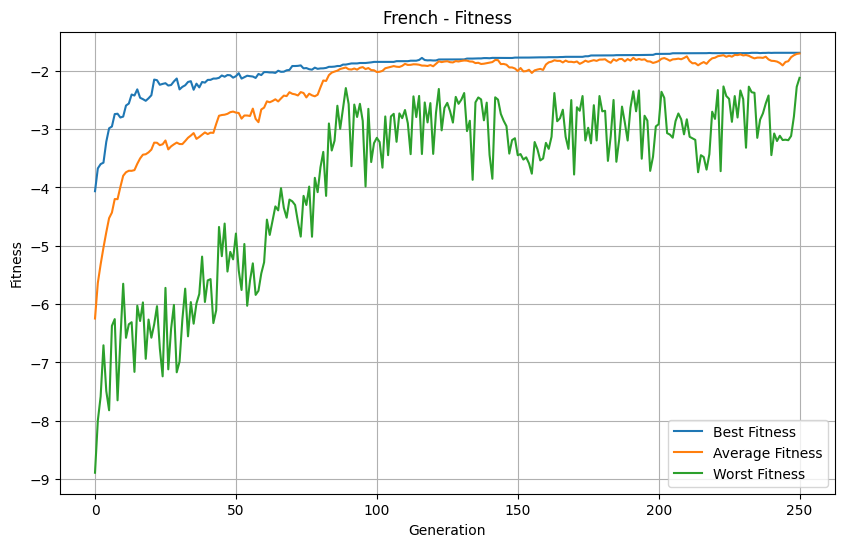

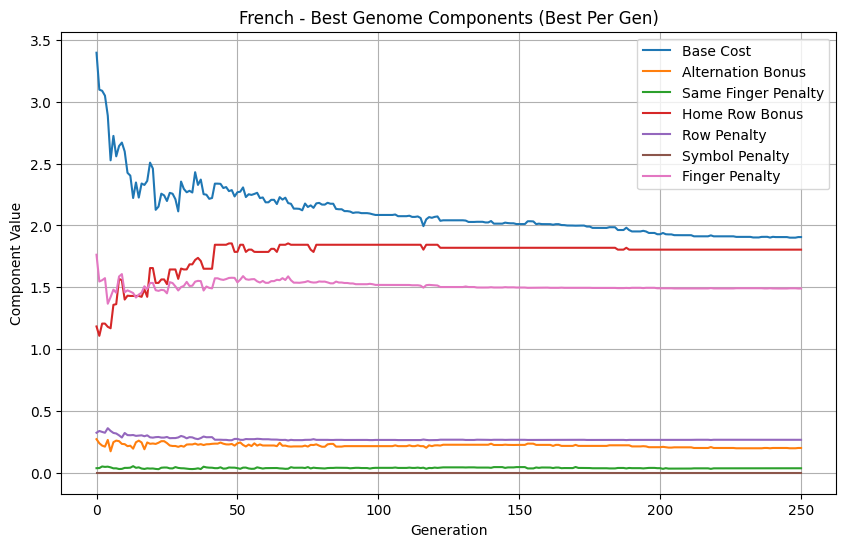

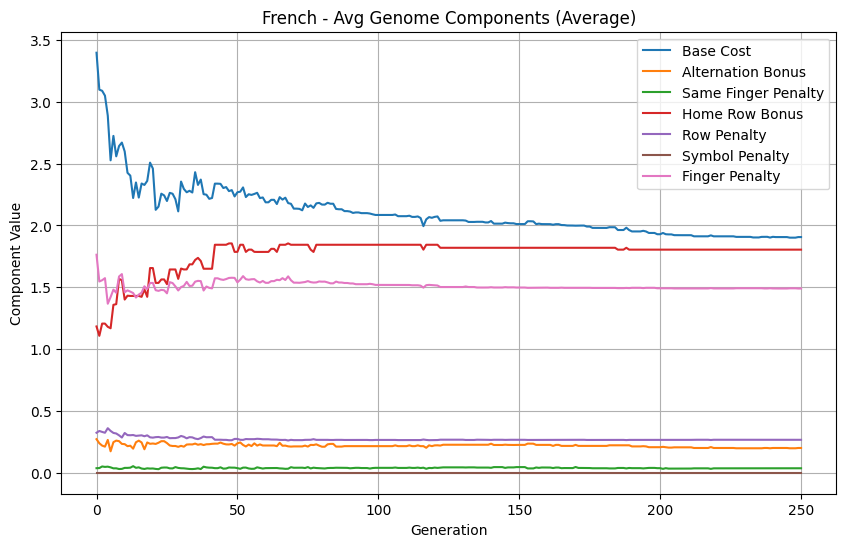

French - Same-finger bigram total: 0


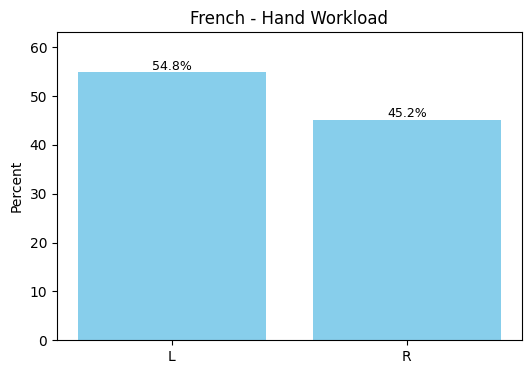

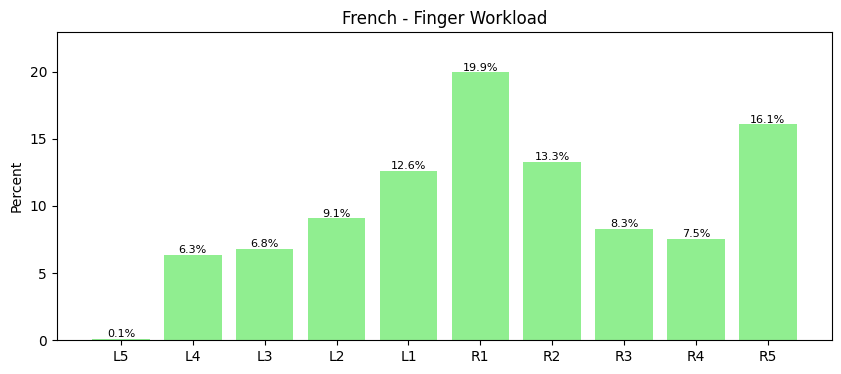

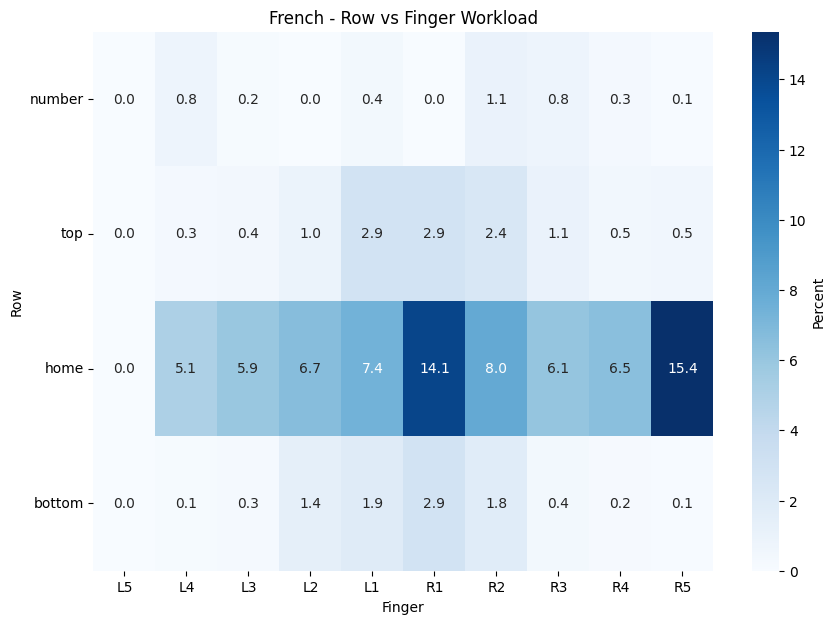

/tmp/ipython-input-2663550021.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle((x, y), w, h, fill=True, color=plt.cm.viridis(intensity), edgecolor='black'))


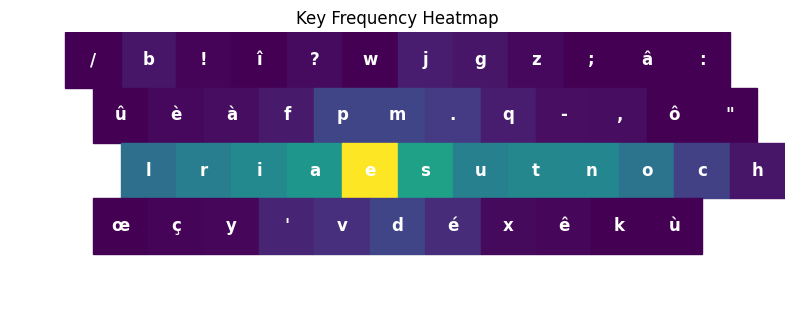

In [ ]:
# Plots
metrics_fr.plot_fitness_curve(df, title="French - Fitness")  # maximize => as_cost=False by default
metrics_fr.plot_component_curves(df, use_avg=False, title="French - Best Genome Components")
metrics_fr.plot_component_curves(df, use_avg=True,  title="French - Avg Genome Components")

# Workload plots for final best layout
layout_fr_best = genome_to_layout(best_genome)
buttons_map = buttons if hasattr(buttons, "values") else {i: b for i, b in enumerate(buttons)}
metrics_fr.plot_final_best_layout(layout_fr_best, buttons_map, char_freq, bigram_freq, run_label="French")

plot_layout_heatmap(layout_fr_best, buttons, char_freq)

/tmp/ipython-input-274456677.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle((x, y), w, h, fill=True, color="#d3d3d3", edgecolor='black'))


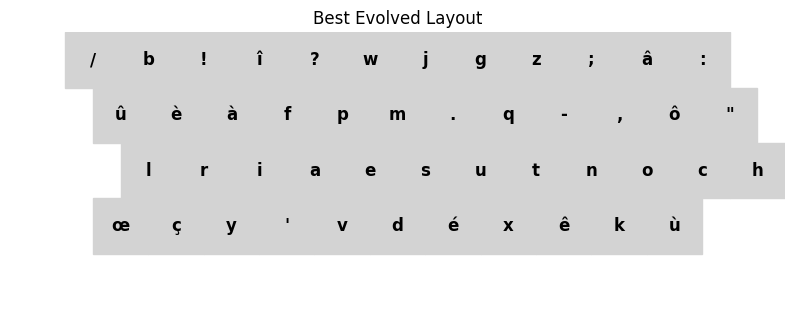

{'alternation_bonus': 0.19776270394541723,
 'base_cost': 1.9009704672313674,
 'coverage': 80.56206088992974,
 'finger_penalty': 1.4914112994005342,
 'fitness': -1.692257098253584,
 'home_row_bonus': 1.804024908088795,
 'layout': 'BEST_FR_GA',
 'missing_bigrams': 415,
 'row_penalty': 0.26601396574989594,
 'same_finger_pct': 15.93861438465093,
 'same_finger_penalty': 0.03564897790599875,
 'symbol_penalty': 0.0}


In [ ]:
def genome_to_layout_dict(genome):
    # indices: 0..11 num row, 12..23 top row, 24..34 home row, 35..44 bottom row
    tn = ''.join(genome[0:12])
    tr = ''.join(genome[12:24])
    hr = ''.join(genome[24:36])
    br = ''.join(genome[36:47])
    return {
        "top_number_row": tn,
        "top_row": tr,
        "home_row": hr,
        "bottom_row": br,
    }

def visualize_best_layout(best_genome, buttons, title="Best Evolved Layout"):
    layout = genome_to_layout(best_genome)
    visualize_keyboard(layout, buttons, title)
    return layout


best_layout = visualize_best_layout(best_genome, buttons)
bestGA = summarize_layout(
    layout_fr_best,
    buttons,
    bigram_freq,
    char_freq,
    name="BEST_FR_GA",
    home_row_indices=get_home_row_indices(azerty_layout, buttons),
)
pprint.pprint(bestGA)

**GETTING 3 HIGH SCORING LAYOUTS FOR LLM TESTING**

Final Best Genome reevaluated: -1.9181
Top 1 score=-1.9181
{'top_number_row': 'ê"w\'œû,g;xçî', 'top_row': '!hbqiucpfà-ô', 'home_row': '.ltsenaromvj', 'bottom_row': ':ykzéd?è/âù'}
Top 2 score=-1.9189
{'top_number_row': 'ê"w\'œû,g;xçî', 'top_row': '!hbqiucpfà-ô', 'home_row': '.ltsenaromvj', 'bottom_row': ':ykzéd?âè/ù'}
Top 3 score=-1.9199
{'top_number_row': 'ê"w\'œû,g;xçî', 'top_row': '!hbqiucpfà-ô', 'home_row': '.ltsenaromvj', 'bottom_row': ':ykzédè?â/ù'}
best layout loaded.


C:\Users\adesh\AppData\Local\Temp\ipykernel_61012\2663550021.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle((x, y), w, h, fill=True, color=plt.cm.viridis(intensity), edgecolor='black'))


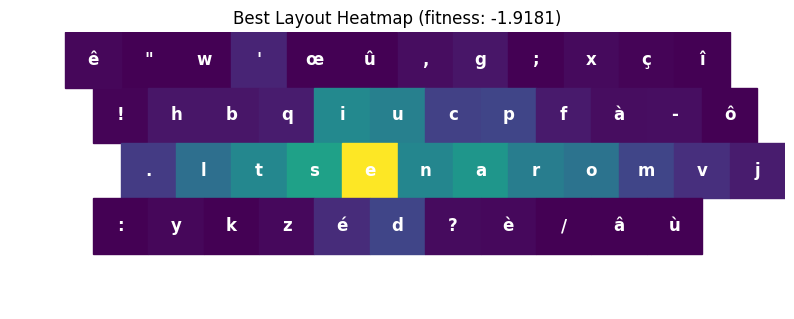

second best layout loaded.


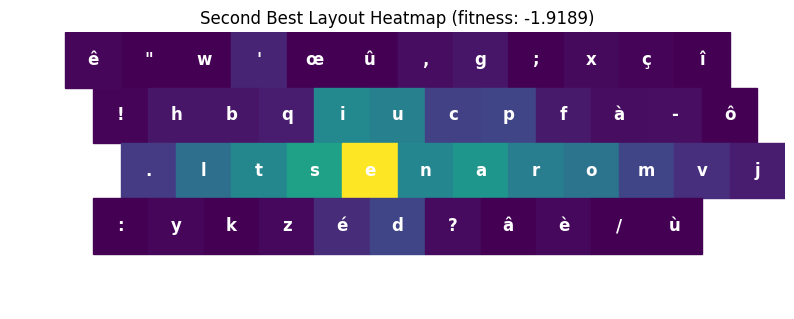

third best layout loaded.


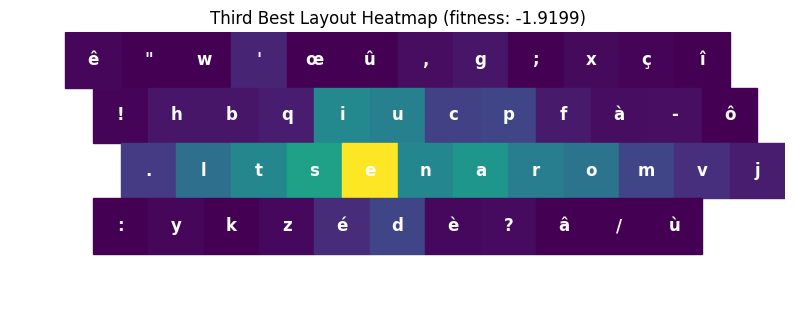

Best Layout → Fitness: -1.9181 | Coverage: 80.56%
First Best → Fitness: -1.9181 | Coverage: 80.56%
Second Best → Fitness: -1.9189 | Coverage: 80.56%
Third Best → Fitness: -1.9199 | Coverage: 80.56%


In [ ]:
final_score = evaluate_genome(best_genome, buttons, bigram_freq, char_freq)
print(f"Final Best Genome reevaluated: {final_score:.4f}")

for i, (gen, sc) in enumerate(top3, 1):
    layout = genome_to_layout_dict(gen)
    print(f"Top {i} score={sc:.4f}")
    print(layout)

first = "ê\"w\'œû,g;xçî!hbqiucpfà-ô.ltsenaromvj:ykzéd?è/âù"
second = "ê\"w\'œû,g;xçî!hbqiucpfà-ô.ltsenaromvj:ykzéd?âè/ù"
third = "ê\"w\'œû,g;xçî!hbqiucpfà-ô.ltsenaromvj:ykzédè?â/ù"

FIRST_CHARS = list(first)
SECOND_CHARS = list(second)
THIRD_CHARS = list(third)

FIRST_CHARS = FIRST_CHARS[:47]
assert len(FIRST_CHARS) == 47
first_layout = CharactersPlacement(
    [{"character": ch, "button_id": i} for i, ch in enumerate(FIRST_CHARS)]
)
print("best layout loaded.")
plot_layout_heatmap(first_layout, buttons, char_freq, title= f"Best Layout Heatmap (fitness: {top3[0][1]:.4f})")

assert len(SECOND_CHARS) == len(buttons)
second_layout = CharactersPlacement(
    [{"character": ch, "button_id": i} for i, ch in enumerate(SECOND_CHARS)]
)
print("second best layout loaded.")
plot_layout_heatmap(second_layout, buttons, char_freq, title= f"Second Best Layout Heatmap (fitness: {top3[1][1]:.4f})")

assert len(THIRD_CHARS) == len(buttons)
third_layout = CharactersPlacement(
    [{"character": ch, "button_id": i} for i, ch in enumerate(THIRD_CHARS)]
)
print("third best layout loaded.")
plot_layout_heatmap(third_layout, buttons, char_freq, title= f"Third Best Layout Heatmap (fitness: {top3[2][1]:.4f})")

for name, layout in [
    ("Best Layout", best_layout),
    ("First Best", first_layout),
    ("Second Best", second_layout),
    ("Third Best", third_layout),
]:
    home_row_indices = get_home_row_indices(layout, buttons)
    score, missing = compute_carpalx_fitness(
        layout, buttons, bigram_freq, char_freq, home_row_indices
    )
    coverage = compute_layout_coverage(layout, bigram_freq)
    print(f"{name} → Fitness: {score:.4f} | Coverage: {coverage:.2%}")

# LLM Testing

In [ ]:
from pathlib import Path
import os, csv, json, datetime
from pydantic import BaseModel, constr, ValidationError
from openai import OpenAI

client = OpenAI()

# --- Paths ---
PROMPT_DIR = Path("prompts")
IMG_DIR = Path("images")
LOG_PATH = Path("logs/api_runs_log.csv")
LOG_PATH.parent.mkdir(parents=True, exist_ok=True)

# --- Schema ---
Row12 = constr(min_length=12, max_length=12)
Row11 = constr(min_length=11, max_length=11)

class KeyboardLayout(BaseModel):
    top_number_row: Row12
    top_row: Row12
    home_row: Row12
    bottom_row: Row11

# --- Allowed characters ---
# Set of allowed characters for the layout to the 47 most common characters in the corpus
ALLOWED_FR = CHARACTER_SET  # This is the full character set for French

def validate_layout_dict(d: dict):
    errors = []
    try:
        tn = d.get("top_number_row") or ""
        tr = d.get("top_row") or ""
        hr = d.get("home_row") or ""
        br = d.get("bottom_row") or ""

        # Length checks (12/12/12/11 = 47)
        if not (len(tn) == 12 and len(tr) == 12 and len(hr) == 12 and len(br) == 11):
            errors.append("row length mismatch (need 12/12/12/11)")

        union = tn + tr + hr + br
        if len(union) != 47:
            errors.append(f"expected 47 total chars, got {len(union)}")

        # Allowed set checks (only if ALLOWED_FR is defined)
        if "ALLOWED_FR" in globals():
            allowed_set = set(ALLOWED_FR)
            extra = sorted(set(union) - allowed_set)
            if extra:
                errors.append(f"contains disallowed chars: {extra}")

            #missing = sorted([ch for ch in allowed_set if union.count(ch) == 0])
            #if missing:
            #    errors.append(f"missing: {missing}")

            dups = sorted([ch for ch in set(union) if union.count(ch) > 1])
            if dups:
                errors.append(f"duplicates: {dups}")

        return (len(errors) == 0), "; ".join(errors)
    except Exception as e:
        return False, f"validator exception: {e}"

def layout_to_charlist(d: dict):
    return list(d["top_number_row"] + d["top_row"] + d["home_row"] + d["bottom_row"])

# --- Safe scoring: never raise, even if rows are wrong or chars are odd ---
def safe_score_layout(d: dict):
    try:
        tn = d.get("top_number_row", "")
        tr = d.get("top_row", "")
        hr = d.get("home_row", "")
        br = d.get("bottom_row", "")
        chars = list(tn + tr + hr + br)

        # Guard: if we don't have 47 positions, we can still try (or bail gracefully)
        if len(chars) != 47:
            return None, None

        layout_obj = CharactersPlacement([{"character": ch, "button_id": i} for i, ch in enumerate(chars)])
        home_row_indices = get_home_row_indices(layout_obj, buttons)
        score, _missing = compute_carpalx_fitness(layout_obj, buttons, bigram_freq, char_freq, home_row_indices)
        coverage = compute_layout_coverage(layout_obj, bigram_freq)
        return score, coverage
    except Exception:
        return None, None

def ensure_log_header():
    if not LOG_PATH.exists():
        with open(LOG_PATH, "w", newline="", encoding="utf-8-sig") as f:
            csv.writer(f).writerow([
                "timestamp","language","prompt_type","prompt_id",
                "temperature","seed","model",
                "valid","reason",
                "fitness","coverage",
                "top_number_row","top_row","home_row","bottom_row"
            ])

def log_row(language, ptype, pid, temp, seed, model, valid, reason, score, coverage, d):
    with open(LOG_PATH, "a", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow([
            datetime.datetime.now().isoformat(timespec="seconds"),
            language, ptype, pid,
            temp, seed, model,
            valid, reason,
            f"{score:.4f}" if score is not None else "",
            f"{coverage:.2%}" if coverage is not None else "",
            d.get("top_number_row","") if d else "",
            d.get("top_row","") if d else "",
            d.get("home_row","") if d else "",
            d.get("bottom_row","") if d else "",
        ])

def load_prompt(code, ptype, pid):
    fname = f"{code}_{ptype}_{pid}.txt"
    return (PROMPT_DIR / fname).read_text(encoding="utf-8")

def lang_name(code):
    return {"EN":"English","FR":"French","AF":"Afrikaans"}[code]

# --- Always log, even if invalid ---
def evaluate_and_log(language, ptype, pid, temp, seed, model, d):
    valid, reason = validate_layout_dict(d)
    score, coverage = safe_score_layout(d)
    log_row(language, ptype, pid, temp, seed, model, valid, reason, score, coverage, d)
    return valid, reason, score, coverage

ensure_log_header()

def find_dupes_and_missing(union, allowed):
    used = list(union)
    counts = {ch: used.count(ch) for ch in set(used)}
    dupes = sorted([ch for ch, c in counts.items() if c > 1])
    missing = sorted(list(set(allowed) - set(used)))
    return dupes, missing

def make_repair_prompt(original_text, layout_dict, dupes, missing):
    # original_text: the FR prompt you used
    # layout_dict: dict with the current (invalid) rows
    return f"""
{original_text}

The previous layout you produced is invalid because some characters are duplicated and some are missing.
Fix ONLY the duplicates by replacing them with the missing characters. Keep the row lengths the same
(12/12/12/11) and keep all characters within the allowed set.

Duplicates: {dupes}
Missing: {missing}

Return only the corrected layout in the exact format:

TOP_NUMBER_ROW:
TOP_ROW:
HOME_ROW:
BOTTOM_ROW:

Current (invalid) layout to repair:
TOP_NUMBER_ROW: {layout_dict.get('top_number_row','')}
TOP_ROW:        {layout_dict.get('top_row','')}
HOME_ROW:       {layout_dict.get('home_row','')}
BOTTOM_ROW:     {layout_dict.get('bottom_row','')}
""".strip()



In [ ]:
# one-time fix to convert existing CSV to UTF-8 with BOM
from pathlib import Path
raw = Path("logs/api_runs_log.csv").read_text(encoding="utf-8", errors="replace")
Path("logs/api_runs_log.csv").write_text(raw, encoding="utf-8-sig")


230587

In [ ]:
def run_no_examples_grid(
    codes=("EN","FR","AF"),
    prompt_ids=(1,2,3),
    temps=(0.0, 0.2, 0.4),
    model="gpt-4.1",
    seed=None
):
    for code in codes:
        language = lang_name(code)
        for pid in prompt_ids:
            prompt_text = load_prompt(code, "no_examples", pid)
            for temp in temps:
                try:
                    resp = client.responses.parse(
                        model=model,
                        input=prompt_text,
                        text_format=KeyboardLayout,
                        temperature=temp,  # remove if unsupported
                        **({"seed": seed} if seed is not None else {})
                    )
                    d = resp.output_parsed.model_dump()
                    valid, reason = validate_layout_dict(d)
                    score, cov = (safe_score_layout(d) if valid else (None, None))
                    log_row(language, "no_examples", pid, temp, seed, model, valid, reason, score, cov, d if valid else {})
                except ValidationError as e:
                    log_row(language, "no_examples", pid, temp, seed, model, False, f"Pydantic: {e}", None, None, {})
                except Exception as e:
                    log_row(language, "no_examples", pid, temp, seed, model, False, str(e), None, None, {})

# English no examples run
for i in range(30):
    print(f"Run {i+1}/30")
    run_no_examples_grid(codes=("FR",), temps=(0.0, 0.2, 0.4))


Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14/30
Run 15/30
Run 16/30
Run 17/30
Run 18/30
Run 19/30
Run 20/30
Run 21/30
Run 22/30
Run 23/30
Run 24/30
Run 25/30
Run 26/30
Run 27/30
Run 28/30
Run 29/30
Run 30/30


In [ ]:
def run_with_examples_grid(
    codes=("EN","FR","AF"),
    prompt_ids=(1,2,3),
    temps=(0.0, 0.2, 0.4),   # temperature values
    model="gpt-4.1"
):
    for code in codes:
        language = lang_name(code)
        for pid in prompt_ids:
            prompt_text = load_prompt(code, "with_examples", pid)
            for temp in temps:
                try:
                    resp = client.responses.parse(
                        model=model,
                        input=prompt_text,
                        text_format=KeyboardLayout,
                        temperature=temp  # remove if SDK errors here
                    )
                    d = resp.output_parsed.model_dump()
                    valid, reason = validate_layout_dict(d)
                    score, cov = (safe_score_layout(d) if valid else (None, None))
                    log_row(language, "with_examples", pid, temp, None, model, valid, reason, score, cov, d if valid else {})
                except ValidationError as e:
                    log_row(language, "with_examples", pid, temp, None, model, False, f"Pydantic: {e}", None, None, {})
                except Exception as e:
                    log_row(language, "with_examples", pid, temp, None, model, False, str(e), None, None, {})


# French with examples run
for i in range(30):
    print(f"Run {i+1}/30")
    run_with_examples_grid(codes=("FR",), temps=(0.0, 0.2, 0.4,))


Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14/30
Run 15/30
Run 16/30
Run 17/30
Run 18/30
Run 19/30
Run 20/30
Run 21/30
Run 22/30
Run 23/30
Run 24/30
Run 25/30
Run 26/30
Run 27/30
Run 28/30
Run 29/30
Run 30/30


In [ ]:
# --- Feedback test (same style as your other tests: responses.parse + Pydantic) ---

from pathlib import Path
from pydantic import ValidationError
import base64, mimetypes

PROMPT_DIR = Path("prompts")
IMG_DIR    = Path("images/feedback")

def load_feedback_prompt(code: str, pid: int) -> str:
    """
    Reads prompts/EN_feedback_1.txt (or FR/AF) and prepends a short JSON-only instruction
    so the model doesn't drift into prose. Your original text remains unchanged.
    """
    p = PROMPT_DIR / f"{code}_feedback_{pid}.txt"
    user_text = p.read_text(encoding="utf-8")
    json_only = (
        "Return ONLY a JSON object with keys: top_number_row, top_row, home_row, bottom_row. "
        "No prose or markdown. Each row is a single string with exact lengths (12,12,12,11). "
        "\n\n"
    )
    return json_only + user_text

def _to_data_url(path: Path) -> str:
    mime = mimetypes.guess_type(str(path))[0] or "image/png"
    b64  = base64.b64encode(path.read_bytes()).decode("ascii")
    return f"data:{mime};base64,{b64}"

def feedback_messages(prompt_text: str, heatmap_path: Path):
    """
    Build multimodal messages for 4o/4.1: text + image (as base64 data URL).
    """
    content = [{"type": "input_text", "text": prompt_text}]
    if heatmap_path and heatmap_path.exists():
        content.append({"type": "input_image", "image_url": _to_data_url(heatmap_path)})
    else:
        print(f"[warn] Heatmap not found: {heatmap_path}")
    return [{"role": "user", "content": content}]

def run_feedback_grid(
    codes=("FR",),           # expand to ("EN","FR","AF")
    prompt_ids=(1,2,3),      # matches EN_feedback_1/2/3.txt and EN_GA_1/2/3.png
    temps=(0.0, 0.2, 0.4),
    model="gpt-4.1"
):
    for code in codes:
        language = lang_name(code)
        for pid in prompt_ids:
            prompt_text  = load_feedback_prompt(code, pid)
            heatmap_path = IMG_DIR / f"{code}_GA_{pid}.png"   # e.g., images/feedback/EN_GA_1.png
            messages     = feedback_messages(prompt_text, heatmap_path)

            for temp in temps:
                try:
                    resp = client.responses.parse(
                        model=model,
                        input=messages,              # multimodal input, same as other tests style
                        text_format=KeyboardLayout,  # enforce schema
                        temperature=temp             # remove if your SDK complains
                    )
                    d = resp.output_parsed.model_dump()

                    valid, reason = validate_layout_dict(d)
                    score, cov = (safe_score_layout(d) if valid else (None, None))

                    # seed is None for 4o runs; keep column for log consistency
                    log_row(language, "feedback", pid, temp, None, model,
                            valid, reason, score, cov, d if valid else {})

                except ValidationError as e:
                    log_row(language, "feedback", pid, temp, None, model,
                            False, f"Pydantic: {e}", None, None, {})
                except Exception as e:
                    log_row(language, "feedback", pid, temp, None, model,
                            False, str(e), None, None, {})


In [ ]:
for i in range(30):
    print(f"Feedback Run {i+1}/30")
    run_feedback_grid(codes=("FR",), temps=(0.0, 0.2, 0.4,))

Feedback Run 1/30
Feedback Run 2/30
Feedback Run 3/30
Feedback Run 4/30
Feedback Run 5/30
Feedback Run 6/30
Feedback Run 7/30
Feedback Run 8/30
Feedback Run 9/30
Feedback Run 10/30
Feedback Run 11/30
Feedback Run 12/30
Feedback Run 13/30
Feedback Run 14/30
Feedback Run 15/30
Feedback Run 16/30
Feedback Run 17/30
Feedback Run 18/30
Feedback Run 19/30
Feedback Run 20/30
Feedback Run 21/30
Feedback Run 22/30
Feedback Run 23/30
Feedback Run 24/30
Feedback Run 25/30
Feedback Run 26/30
Feedback Run 27/30
Feedback Run 28/30
Feedback Run 29/30
Feedback Run 30/30
